## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
        
    plt.show()

In [3]:
%matplotlib inline

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [12]:
# checkpoint_path = "pretrained/tacotron2_statedict.pt"
checkpoint_path = "model_checkpoints/checkpoint_final_781"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()#.half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [13]:
waveglow_path = 'pretrained/waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
# waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

d:\pycharmprojects\tacotron2\venv37\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
d:\pycharmprojects\tacotron2\venv37\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
d:\pycharmprojects\tacotron2\venv37\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code 

#### Prepare text input

In [14]:
text = "Waveglow is really awesome!"
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

Warning! Reached max decoder steps


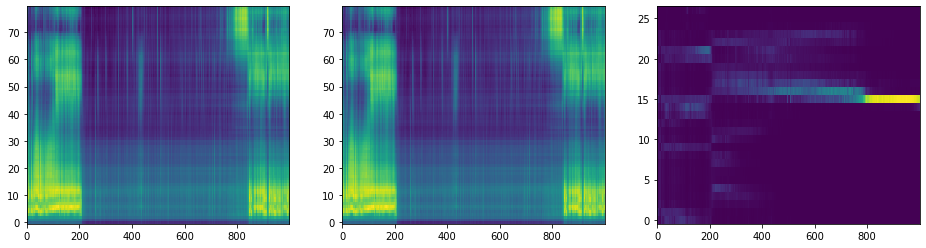

In [15]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [16]:
mel_outputs_postnet

tensor([[[-7.5813, -7.4874, -7.0064,  ..., -6.9537, -6.8961, -6.9771],
         [-7.1266, -6.5920, -6.1295,  ..., -5.9968, -5.9416, -5.9364],
         [-6.4148, -6.0528, -5.1681,  ..., -5.1756, -5.1199, -5.0721],
         ...,
         [-8.3014, -7.1035, -7.3090,  ..., -4.6104, -4.6360, -4.8956],
         [-8.2290, -6.9485, -7.2356,  ..., -4.7270, -4.7586, -5.0428],
         [-8.2709, -7.0775, -7.3038,  ..., -4.9909, -5.0374, -5.3336]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [17]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [29]:
audio[0]

tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       dtype=torch.float16)

#### (Optional) Remove WaveGlow bias

In [17]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 